NAME: __TODO: FULLNAME__

# Machine Learning Practice - Asynchronous
## Homework 03: Classifiers

### Objectives
* Compute class labels from raw data
* Use your imputing/filtering skills to clean up raw data
* Implement a classifier that predicts robot motion from infant movements
* Evaluate the classifier by:
  + Using built-in cross-validation tools
  + Computing TPR/FPRs
  + Displaying their CDFs
  + Displaying the corresponding ROC curve

### Instructions
* Read the code below 
* For any cell that is flagged as *TODO*, complete the code according to the specifications
* Execute each cell and verify that it is showing correct results
* Hand-In Procedure
  + Make sure that your notebook has been saved
  + Download this file to your local machine (extension: .ipynb)
  + Submit to the Gradscope Notebook HW03 dropbox

### General References
* [Python Built-in Functions](https://docs.python.org/3/library/functions.html)
* [Python Data Structures](https://docs.python.org/3/tutorial/datastructures.html)
* [Numpy Reference](https://docs.scipy.org/doc/numpy/reference/index.html)
* [Summary of matplotlib](https://matplotlib.org/3.1.1/api/pyplot_summary.html)
* [Pandas DataFrames](https://urldefense.proofpoint.com/v2/url?u=https-3A__pandas.pydata.org_pandas-2Ddocs_stable_reference_api_pandas.DataFrame.html&d=DwMD-g&c=qKdtBuuu6dQK9MsRUVJ2DPXW6oayO8fu4TfEHS8sGNk&r=9ngmsG8rSmDSS-O0b_V0gP-nN_33Vr52qbY3KXuDY5k&m=mcOOc8D0knaNNmmnTEo_F_WmT4j6_nUSL_yoPmGlLWQ&s=h7hQjqucR7tZyfZXxnoy3iitIr32YlrqiFyPATkW3lw&e=)
* [Sci-kit Learn Linear Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)
  + [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)
* [Sci-kit Learn Ensemble Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)
* [Sci-kit Learn Metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
* [Sci-kit Learn Model Selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)



In [109]:
import pandas as pd
import numpy as np
import os, re, fnmatch
import matplotlib.pyplot as plt
import matplotlib.patheffects as peffects

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
import scipy.stats as stats

# Default figure parameters
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

%matplotlib inline

In [110]:
# Execute only if using CoLab
#from google.colab import drive
#drive.mount('/content/drive')

# LOAD DATA

In [111]:
""" PROVIDED
Load data from subject k2 for week 5
Display info() for the data

These are data obtained from a baby on the SIPPC. 3D Position (i.e. kinematic)
data are collected at 50 Hz, for the x, y, and z positions in meters, for 
various joints such as the wrists, elbows, shoulders, etc.
"""
# JupyterHub file name
fname = '/mlp/datasets/baby1/subject_k2_w05.csv'

baby_data_raw = pd.read_csv(fname) 
baby_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              15000 non-null  float64
 1   left_wrist_x      14987 non-null  float64
 2   left_wrist_y      14987 non-null  float64
 3   left_wrist_z      14987 non-null  float64
 4   right_wrist_x     14984 non-null  float64
 5   right_wrist_y     14984 non-null  float64
 6   right_wrist_z     14984 non-null  float64
 7   left_elbow_x      15000 non-null  float64
 8   left_elbow_y      15000 non-null  float64
 9   left_elbow_z      15000 non-null  float64
 10  right_elbow_x     15000 non-null  float64
 11  right_elbow_y     15000 non-null  float64
 12  right_elbow_z     15000 non-null  float64
 13  left_shoulder_x   15000 non-null  float64
 14  left_shoulder_y   15000 non-null  float64
 15  left_shoulder_z   15000 non-null  float64
 16  right_shoulder_x  15000 non-null  float6

In [112]:
""" TODO
Display the first few examples
"""
# TODO
baby_data_raw.head()

,time,left_wrist_x,left_wrist_y,left_wrist_z,right_wrist_x,right_wrist_y,right_wrist_z,left_elbow_x,left_elbow_y,left_elbow_z,...,left_foot_z,right_foot_x,right_foot_y,right_foot_z,upper_back_x,upper_back_y,upper_back_z,sippc_action,robot_vel_l,robot_vel_r
0,0.00,0.220415,0.181230,-0.129179,0.234461,-0.235074,-0.058906,0.172050,0.227567,-0.052032,...,-0.117939,-0.214891,-0.051161,-0.248173,0.225993,0.012226,0.021536,0.0,-0.000181,0.004893
1,0.02,0.221667,0.180757,-0.128407,0.233129,-0.237052,-0.058938,0.173125,0.227220,-0.051447,...,-0.123085,-0.215723,-0.051426,-0.248049,0.226178,0.011346,0.021050,0.0,-0.000178,0.004820
2,0.04,0.222194,0.180795,-0.127102,0.231888,-0.238736,-0.058754,0.173883,0.227297,-0.050020,...,-0.122420,-0.217153,-0.052046,-0.247054,0.226289,0.010714,0.020789,0.0,-0.000175,0.004748
3,0.06,0.222396,0.181160,-0.126370,0.230835,-0.240115,-0.058329,0.174341,0.227243,-0.048877,...,-0.121519,-0.218098,-0.052721,-0.246157,0.226414,0.010120,0.020412,0.0,-0.000173,0.004677
4,0.08,0.223019,0.182199,-0.124856,0.230171,-0.241552,-0.058468,0.174702,0.227184,-0.046883,...,-0.122356,-0.219171,-0.053410,-0.244805,0.226513,0.009397,0.020212,0.0,-0.000170,0.004609


In [113]:
""" TODO
Display the last few examples
"""
# TODO
baby_data_raw.tail()

,time,left_wrist_x,left_wrist_y,left_wrist_z,right_wrist_x,right_wrist_y,right_wrist_z,left_elbow_x,left_elbow_y,left_elbow_z,...,left_foot_z,right_foot_x,right_foot_y,right_foot_z,upper_back_x,upper_back_y,upper_back_z,sippc_action,robot_vel_l,robot_vel_r
14995,299.90,0.305730,0.168831,0.033561,0.259778,-0.171445,0.045665,0.238274,0.244787,0.044443,...,-0.212863,-0.072385,-0.137549,-0.260178,0.192844,0.022664,0.080014,8.0,0.001891,0.055393
14996,299.92,0.305648,0.167093,0.034346,0.260100,-0.170313,0.046645,0.239116,0.243905,0.044899,...,-0.213741,-0.071297,-0.136961,-0.260497,0.192431,0.022375,0.080498,8.0,0.001887,0.055518
14997,299.94,0.306012,0.165883,0.035369,0.260067,-0.169648,0.047763,0.240050,0.243200,0.045813,...,-0.214687,-0.070472,-0.136552,-0.260672,0.192087,0.022130,0.080898,8.0,0.001884,0.055618
14998,299.96,0.306393,0.165342,0.036705,0.260300,-0.169104,0.048301,0.240694,0.242808,0.047692,...,-0.215449,-0.070135,-0.136213,-0.260645,0.191871,0.021943,0.081155,8.0,0.001880,0.055695
14999,299.98,0.307053,0.165342,0.038167,0.260593,-0.168929,0.048783,0.241236,0.242589,0.049956,...,-0.215919,-0.070001,-0.136121,-0.260579,0.191652,0.021846,0.081390,8.0,0.001878,0.055752


In [114]:
""" TODO
Display the summary statistics
"""
baby_data_raw.describe()

,time,left_wrist_x,left_wrist_y,left_wrist_z,right_wrist_x,right_wrist_y,right_wrist_z,left_elbow_x,left_elbow_y,left_elbow_z,...,left_foot_z,right_foot_x,right_foot_y,right_foot_z,upper_back_x,upper_back_y,upper_back_z,sippc_action,robot_vel_l,robot_vel_r
count,15000.000000,14987.000000,14987.000000,14987.000000,14984.000000,14984.000000,14984.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,149.990000,0.244686,0.125995,-0.016250,0.222374,-0.153784,-0.021553,0.203240,0.157987,0.002500,...,-0.228861,-0.073937,-0.050101,-0.235308,0.183821,-0.025163,0.065818,1.143400,-0.000345,0.003076
std,86.605427,0.049269,0.102700,0.096238,0.060946,0.042294,0.045206,0.046069,0.062485,0.052760,...,0.067573,0.097112,0.045566,0.028536,0.026734,0.046388,0.020480,2.498917,0.004045,0.028319
min,0.000000,0.083382,-0.034872,-0.177069,0.106451,-0.274525,-0.124859,0.110774,0.064651,-0.092058,...,-0.327945,-0.256544,-0.160185,-0.297654,0.133454,-0.092531,0.011274,0.000000,-0.014122,-0.074040
25%,74.995000,0.220650,0.027081,-0.119591,0.170334,-0.177999,-0.060396,0.161956,0.098481,-0.050257,...,-0.285460,-0.164332,-0.088158,-0.254496,0.162355,-0.069502,0.052854,0.000000,-0.001392,-0.012675
50%,149.990000,0.249578,0.126924,-0.010748,0.202907,-0.137865,-0.027056,0.201472,0.140740,0.020384,...,-0.248474,-0.028150,-0.048895,-0.241090,0.174270,-0.046750,0.070823,0.000000,-0.000036,0.001257
75%,224.985000,0.270780,0.227609,0.073605,0.283243,-0.125323,0.011331,0.247348,0.222750,0.035858,...,-0.177103,0.012705,-0.017788,-0.215172,0.209942,0.022537,0.080999,0.000000,0.000716,0.019756
max,299.980000,0.370966,0.320520,0.154593,0.329078,-0.071355,0.151956,0.284781,0.260276,0.176419,...,0.000970,0.035922,0.089456,-0.140069,0.226768,0.047361,0.104098,8.000000,0.016195,0.077659


# Data Selection

In [115]:
""" PROVIDED
"""
## Support for identifying kinematic variable columns
def get_kinematic_properties(data):
    # Regular expression for finding kinematic fields
    regx = re.compile("_[xyz]$")

    # Find the list of kinematic fields
    fields = list(data)
    fieldsKin = [x for x in fields if regx.search(x)]
    return fieldsKin

def position_fields_to_velocity_fields(fields, prefix='d_'):
    '''
    Given a list of position columns, produce a new list
    of columns that include both position and velocity
    '''
    fields_new = [prefix + x for x in fields]
    return fields + fields_new


In [116]:
""" PROVIDED
Get the names of the sets of fields for the kinematic features and the 
velocities
"""
fieldsKin = get_kinematic_properties(baby_data_raw)
fieldsKinVel = position_fields_to_velocity_fields(fieldsKin)
print(fieldsKinVel)

"""
Fields that describe the linear and rotational velocities of the robot
"""
fieldsRobot = ['robot_vel_l', 'robot_vel_r']


['left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'left_foot_x', 'left_foot_y', 'left_foot_z', 'right_foot_x', 'right_foot_y', 'right_foot_z', 'upper_back_x', 'upper_back_y', 'upper_back_z', 'd_left_wrist_x', 'd_left_wrist_y', 'd_left_wrist_z', 'd_right_wrist_x', 'd_right_wrist_y', 'd_right_wrist_z', 'd_left_elbow_x', 'd_left_elbow_y', 'd_left_elbow_z', 'd_right_elbow_x', 'd_right_elbow_y', 'd_right_elbow_z', 'd_left_shoulder_x', 'd_left_shoulder_y', 'd_left_shoulder_z', 'd_right_shoulder_x', 'd_right_shoulder_y', 'd_right_shoulder_z', 

# Construct Pipeline Components

In [117]:
""" PROVIDED
"""
# Pipeline component: select subsets of attributes
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribs):
        self.attribs = attribs
    def fit(self, x, y=None):
        return self
    def transform(self, X):
        return X[self.attribs]

# Pipeline component: drop all rows that contain invalid values
class DataSampleDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, x, y=None):
        return self
    def transform(self, X):
        return X.dropna(how='any')

"""
PROVIDED

Complete the Pipeline component object for interpolating and filling in 
gaps within the data. Whenever data are missing in between valid values, 
use interpolation to fill in the gaps. For example,
    1.2 NaN NaN 1.5 
becomes
    1.2 1.3 1.4 1.5 

Whenever data are missing on the edges of the data, fill in the gaps
with the first available valid value. For example,
    NaN NaN 2.3 3.6 3.2 NaN
becomes
    2.3 2.3 2.3 3.6 3.2 3.2
The transform() method you create must fill in the holes and the edge cases.

Hint: there are DataFrame methods that will help you implement these features
"""
class InterpolationImputer(BaseEstimator, TransformerMixin):
    def __init__(self, method='quadratic'):
        self.method = method
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X): # TODO
        '''
        :param X: is a DataFrame
        :return: DataFrame without NaNs
        '''
        Xout = X.interpolate(method=self.method)
        
        Xout.fillna(method='ffill', inplace=True)
        Xout.fillna(method='bfill', inplace=True)
        
        # Return the imputed dataframe
        return Xout

def computeGaussianWeights(length=3, sig=1):
    '''
    PROVIDED
    
    Computes the weights for a Gaussian filter kernel
    :param length: the number of terms in the filter kernel
    :param sig: the standard deviation (i.e. the scale) of the Gaussian
    :return: a vector of filter weights for the Gaussian kernel
    '''
    limit = 2.5
    x = np.linspace(-limit, limit, length)
    kernel = stats.norm.pdf(x, scale=sig)
    
    # Return the normalized kernel so that the sum is 1
    return kernel / kernel.sum()


class Filter(BaseEstimator, TransformerMixin):
    '''
    PROVIDED

    General Filter class.  Note that the API is a little different than the last homework
    assignment - this one can be used for any type of filter
    '''
    def __init__(self, attribs=None, kernel=np.zeros((0,))):
        '''
        Constructor
        
        :param attribs: List of column names to filter
        :param kernel: A vector kernel to be used for filtering.  Kernel must have an odd length.
        '''
        # Attributes to filter
        self.attribs = attribs
        
        # Number of kernel elements 
        self.kernelsize = kernel.shape[0]
        
        # Check that we have an odd kernel size
        if self.kernelsize % 2 == 0:
            raise Exception("Expecting an odd kernel size")
        
        # Compute the kernel element values
        self.weights = kernel
            
    def fit(self, x, y=None):
        return self
    
    def transform(self, X): 
        '''
        :param X: is a DataFrame
        :return:: a DataFrame with the smoothed signals
        '''
        w = self.weights
        # Create a copy of the original DataFrame
        Xout = X.copy()
        
        # Select all attributes if unspecified
        if self.attribs is None:
          self.attribs = Xout.columns
        
        # Iterate over the attributes
        for attrib in self.attribs:
            # Extract the numpy vector
            vals = Xout[attrib].values
            # Pad signal at both the front and end of the vector so that after
            #   convolution, the length is the same as the lenght of vals.  Use 
            #   vals[0] and vals[-1] to pad the front and back, respectively.
            #   You may assume that the kernel size is always odd
            
            pad_size = self.kernelsize // 2 # integer division
            
            # Compute the front and back padding vectors
            frontpad = [vals[0]] * pad_size  
            backpad = [vals[-1]] * pad_size  
            vals = np.concatenate((frontpad, vals, backpad))
            
            # Apply filter
            # Implementation is the same as for the DerivativeComputer element, but
            #   more general.  You must iterate over the kernel elements.
            #   (NOTE: due to the wonky way indexing works in python, you will have
            #   specific code for one index & iterate over the remaining k-1 indices)
            
            
            # Filter window offset
            ofst = self.kernelsize - 1 
            # Last term
            vec = w[ofst] * vals[ofst:] 
            
            # Rest of the terms
            for i in range(ofst): 
                vec += w[i] * vals[i:(-ofst+i)]
            
            # replace noisy signal with filtered signal
            Xout[attrib] = pd.Series(vec)
        return Xout
    

class DerivativeComputer(BaseEstimator, TransformerMixin):
    """ 
    PROVIDED

    Pipeline component object for computing the derivative for specified features
    """
    
    def __init__(self, attribs=None, prefix='d_', dt=1.0):
        '''
        Constructor
        :param attribs: List of columns to compute the derivative for
        :param prefix: A new column is added to the data frame of the form prefix+name
        :param dt: Period between samples in the timeseries
        '''
        self.attribs = attribs
        self.prefix = prefix
        self.dt = dt
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        '''
        :param X: a DataFrame
        :return: a DataFrame with additional features for the derivatives
        '''
        Xout = X.copy()
        if self.attribs is None:
            self.attribs = Xout.columns

        # Iterate over all of the attributes that we need to compute velocity over
        for attrib in self.attribs:
            # Extract the numpy array of data
            vals = Xout[attrib].values
            # Compute the difference between neighboring timeseries elements
            diff = vals[1:] - vals[0:-1]
            # Take into account the amount of time between timeseries samples
            deriv = diff / self.dt
            # Add a zero to the end so the resulting velocity vector is the same
            #   length as the position vector
            deriv = np.append(deriv, 0)
            
            # Add a new derivative attribute to the DataFrame
            attrib_name = self.prefix + attrib
            Xout[attrib_name] = pd.Series(deriv)

        return Xout

# Construct Pipelines

In [118]:
""" TODO
Create four pipelines. 

The first pipeline is used for the raw dataframe:
1.  Impute values for the kinematic features
2.  Smooth the kinematic features.  Use a Gaussian kernel of length 11 and standard deviation of 6
3.  Compute derivatives of all of the kinematic features.  dt is 0.02 seconds
The output is a cleaned data frame.

The cleaned data frame will be input to several additional pipelines:

The second pipeline extracts the kinematic and velocity (derivative)
features from the dataframe.

The third pipeline extracts the time stamp from the dataframe.

The fourth pipeline extracts the robot velocity from the dataframe (both the linear and rotational velocity).
"""
# Sampling rate: number of seconds between each time sample
dt = .02

# TODO: create instances of the needed individual pipeline elements
#1
imputer = InterpolationImputer()

#2
gaussian_weights = computeGaussianWeights(length=11, sig=6)
smoother = Filter(attribs=fieldsKin, kernel=gaussian_weights)

#3
derivative_computer = DerivativeComputer(attribs=fieldsKin, dt=dt)

# TODO: Initial pre-processing: Pipeline #1
pipeline1 = Pipeline([
    ("imputer", imputer),
    ("smoother", smoother),
    ("derivative_computer", derivative_computer)
])

# TODO: Position, velocity selector: Pipeline #2
pipeline2 = Pipeline([
    ("selector", DataFrameSelector(fieldsKinVel))
])

# TODO: Time selector: Pipeline #3
pipeline3 = Pipeline([
    ("selector", DataFrameSelector(["time"]))
])

# TODO: Robot velocity selector: Pipeline #4
pipeline4 = Pipeline([
    ("selector", DataFrameSelector(fieldsRobot))
])


In [119]:
fieldsKinVel

['left_wrist_x',
 'left_wrist_y',
 'left_wrist_z',
 'right_wrist_x',
 'right_wrist_y',
 'right_wrist_z',
 'left_elbow_x',
 'left_elbow_y',
 'left_elbow_z',
 'right_elbow_x',
 'right_elbow_y',
 'right_elbow_z',
 'left_shoulder_x',
 'left_shoulder_y',
 'left_shoulder_z',
 'right_shoulder_x',
 'right_shoulder_y',
 'right_shoulder_z',
 'left_knee_x',
 'left_knee_y',
 'left_knee_z',
 'right_knee_x',
 'right_knee_y',
 'right_knee_z',
 'left_ankle_x',
 'left_ankle_y',
 'left_ankle_z',
 'right_ankle_x',
 'right_ankle_y',
 'right_ankle_z',
 'left_foot_x',
 'left_foot_y',
 'left_foot_z',
 'right_foot_x',
 'right_foot_y',
 'right_foot_z',
 'upper_back_x',
 'upper_back_y',
 'upper_back_z',
 'd_left_wrist_x',
 'd_left_wrist_y',
 'd_left_wrist_z',
 'd_right_wrist_x',
 'd_right_wrist_y',
 'd_right_wrist_z',
 'd_left_elbow_x',
 'd_left_elbow_y',
 'd_left_elbow_z',
 'd_right_elbow_x',
 'd_right_elbow_y',
 'd_right_elbow_z',
 'd_left_shoulder_x',
 'd_left_shoulder_y',
 'd_left_shoulder_z',
 'd_right_sho

## Pre-process and extract data

In [120]:
""" TODO
Use the above pipelines to extract the data with kinematic and velocity features, 
the time, and the robot velocity.

See the lecture on classifers for examples.
"""
# TODO: use the first pipeline to perform an initial cleaning of the data
baby_data_clean =pipeline1.fit_transform(baby_data_raw)

# TODO: Use the result from the first pipeline to extract the kinematic and 
#       velocity features by using the pipe_kin_vel pipeline
data_pos_vel = pipeline2.fit_transform(baby_data_clean)

# TODO: Use the result from the first pipeline to extract the time stamps by using
#       the pipe_time pipeline
data_time = pipeline3.fit_transform(baby_data_clean)


# TODO: Use the result from the first pipeline to get the robot velocity by using
#       the pipe_robot_vel pipeline
data_robot_vel = pipeline4.fit_transform(baby_data_clean)

# PROVIDED: Transform the dataframes as numpy arrays
inputs_pos_vel = data_pos_vel.values
time = data_time.values
robot_vel = data_robot_vel.values

nsamples = robot_vel.shape[0]


## Examine Robot Velocity

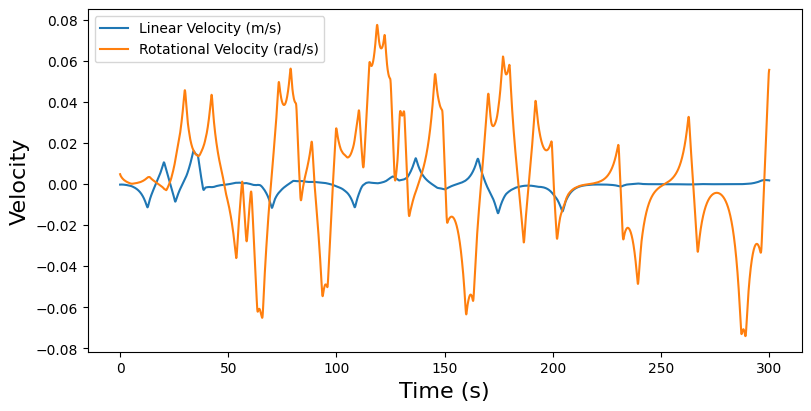

In [121]:
""" TODO
Create a plot that contains both the linear velocity (robot_vel[:,0]) and
rotational velocity (robot_vel[:,1]).  The plot should contain appropriate labels

Note: units are m/s and rad/s, respectively
"""

plt.figure()

# TODO
plt.plot(time, robot_vel[:, 0], label='Linear Velocity (m/s)')
plt.plot(time, robot_vel[:, 1], label='Rotational Velocity (rad/s)')
plt.xlabel("Time (s)")
plt.ylabel("Velocity")
plt.legend(['Linear Velocity (m/s)', 'Rotational Velocity (rad/s)'], loc='upper left')

In [122]:
""" PROVIDED
Create labels that correspond to "fast forward motion" and
"fast left rotational motion"

"""
# Fast forward motion
labels_linear = robot_vel[:,0] > 0.001

# Leftward turns
labels_rotational = (robot_vel[:,1]) > 0.002

#display 
labels_linear[:10], labels_rotational[:10]

(array([False, False, False, False, False, False, False, False, False,
        False]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]))

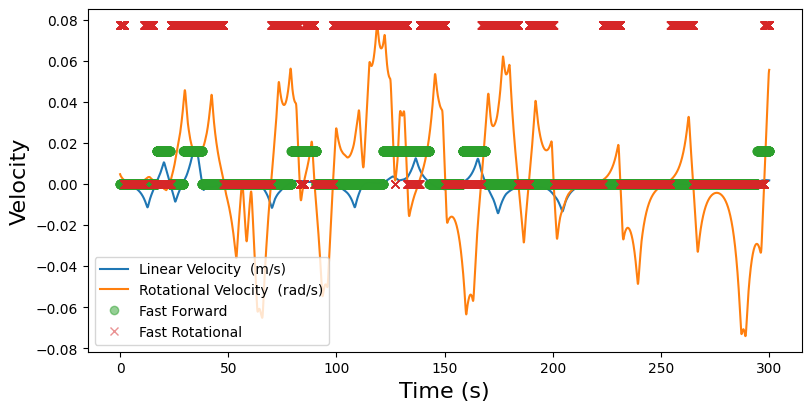

In [123]:
""" TODO
Augment the figure you created above to show the two newly-created
class labels.  Make sure that the resulting figure is easy to read
"""
plt.figure()

plt.plot(time, robot_vel[:, 0], label='Linear Velocity (m/s)')
plt.plot(time, robot_vel[:, 1], label='Rotational Velocity (rad/s)')

# scaling 
scale_factor_linear =max(robot_vel[:,0])
scale_factor_rotational = max (robot_vel[:,1])

# Plotting the labels for Fast Forward motion and Fast Rotational motion
plt.plot(time, labels_linear*scale_factor_linear, 'o', label='Fast Forward', alpha=0.5)
plt.plot(time, labels_rotational*scale_factor_rotational, 'x', label='Fast Rotational', alpha=0.5) 

plt.xlabel("Time (s)")
plt.ylabel("Velocity")
plt.legend(['Linear Velocity  (m/s)', 'Rotational Velocity  (rad/s)',
           'Fast Forward', 'Fast Rotational'], loc='lower left')

## First Classifier
Create an instance of the SGDClassifier and fit our entire data set using this data.

Details: Random_state=42, max_iter=1e4, tol=1e-3, and
that uses the log_loss function. Fit the model using the position x, y, z
and velocity x, y, z for all limbs as the input features to the model. Use
the robot linear velocity labels as the output of the model.

In [124]:
""" TODO
"""
# Input
X = inputs_pos_vel

# Desired output
y = labels_linear

# TODO: Create and fit the classifer
clf = SGDClassifier(random_state=42 , max_iter=int(1e4) ,tol=1e-3 ,loss='log')
clf.fit(X,y)

# TODO: extract the predictions and the decision function scores from the model for the entire data set
preds = clf.predict(X)

scores =clf.decision_function(X)

c:\Users\kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [125]:
""" PROVIDED
"""
# Generate a color map plot for a confusion matrix
def confusion_mtx_colormap(mtx, xnames, ynames, cbarlabel="", FIGWIDTH=5, FIGHEIGHT=5, FONTSIZE=14):
    ''' 
    Generate a figure that plots a colormap of a matrix
    PARAMS:
        mtx: matrix of values
        xnames: list of x tick names
        ynames: list of the y tick names
        cbarlabel: label for the color bar
    RETURNS:
        fig, ax: the corresponding handles for the figure and axis
    '''
    nxvars = mtx.shape[1]
    nyvars = mtx.shape[0]
    
    # create the figure and plot the correlation matrix
    fig, ax = plt.subplots(figsize=(FIGWIDTH, FIGHEIGHT))
    im = ax.imshow(mtx, cmap='summer')
    if not cbarlabel == "":
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    
    # Specify the row and column ticks and labels for the figure
    ax.set_xticks(range(nxvars))
    ax.set_yticks(range(nyvars))
    ax.set_xticklabels(xnames)
    ax.set_yticklabels(ynames)
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("Actual Labels")

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, 
             ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    lbl = np.array([['TN', 'FP'], ['FN', 'TP']])
    for i in range(nyvars):
        for j in range(nxvars):
            text = ax.text(j, i, "%s = %.3f" % (lbl[i,j], mtx[i, j]),
                           ha="center", va="center", color="k")
            #text.set_path_effects([peffects.withStroke(linewidth=2, 
            #foreground='w')])

    return fig, ax


def display_confusion_matrix(y, preds, label_names):
    """ 
    Compute the confusion matrix using sklearn's confusion_matrix() function and 
    generate a color map using the provided confusion_mtx_colormap() for the model 
    built using the distance labels.
    
    :params y: Ground truth labels
    :params preds: Crisp predictions made by the model (i.e., after thresholding)
    :return: Number of positive and negative examples (ground truth)
    """
    dist_confusion_mtx = confusion_matrix(y, preds)
    confusion_mtx_colormap(dist_confusion_mtx, label_names, label_names, cbarlabel="") # TODO

    nneg = dist_confusion_mtx[0].sum()
    npos = dist_confusion_mtx[1].sum()
    return npos, nneg

In [126]:

'''
TODO: Complete the visualization implementations
'''
def visualize_model_output_timeseries(y, preds, scores, threshold=0, offset_pred=-2, offset_scores=-8):
    '''
    Plot timeseries on a single axis:
    1. True class (y)
    2. Predicted class (preds)
    3. Prediction scores (scores)
    
    In addition, draw a horizontal line over the scores that shows the decision threshold (by default
    the decision threshold is zero)
    
    Don't forget to supply a meaningful legend and to label the horizontal axis
    '''
    
    plt.figure()
    plt.plot(y,label='True Class')
    plt.plot(preds + offset_pred ,label="Predicted Class")
    plt.plot(scores + offset_scores ,label = "Scores")
    plt.axhline(y=threshold + offset_scores , color='r', linestyle = '--',label ='Threhold')
    plt.xlabel("Time (s)")
    plt.ylabel("Class")
    plt.legend()
    
    
'''
TODO

Compute the ROC Curve and generate the KS plot
'''
def ks_roc_plot(targets, scores, FIGWIDTH=12, FIGHEIGHT=6, FONTSIZE=16):
    ''' 
    Generate a figure that plots the ROC Curve and the distributions of the 
    TPR and FPR over a set of thresholds
    PARAMS:
        targets: list of true target labels
        scores: list of predicted labels or scores
    RETURNS:
        fpr: false positive rate
        tpr: true positive rate
        thresholds: thresholds used for the ROC curve
        auc: Area under the ROC Curve
        fig, axs: corresponding handles for the figure and axis
    '''
    fpr, tpr, thresholds = roc_curve(targets, scores) # TODO
    auc_res = auc(fpr, tpr)  # TODO

    # Generate figure with two axes
    fig, ax = plt.subplots(1, 2, figsize=(FIGWIDTH,FIGHEIGHT))
    axs = ax.ravel()  # Individual axes are ax[0] and ax[1]
    
    # TODO: plot TPR, FPR and difference
    ax[0].plot(thresholds, tpr, color='b')
    ax[0].plot(thresholds, fpr, color='r')
    ax[0].plot(thresholds, tpr - fpr , color='g')
    
    ax[0].set_xlabel('threshold', fontsize=FONTSIZE)
    ax[0].set_ylabel('Fraction', fontsize=FONTSIZE)
    ax[0].legend(['TPR', 'FPR', 'Difference'], fontsize=FONTSIZE)
    
    # TODO: Generate ROC Curve plot
    ax[1].plot(fpr, tpr, color='b')
    ax[1].plot([0, 1], [0, 1], color='r', linestyle='--')
    
    ax[1].set_xlabel('FPR', fontsize=FONTSIZE)
    ax[1].set_ylabel('TPR', fontsize=FONTSIZE)
    ax[1].set_aspect('equal', 'box')
    auc_text = ax[1].text(.05, .95, "AUC = %.4f" % auc_res, 
                          color="k", fontsize=FONTSIZE)
    print("AUC:", auc_res)

    return fpr, tpr, thresholds, auc_res, fig, axs


""" 
TODO

Plot histograms of the scores from the model.
"""

def plot_score_histograms(scores, y, nbins = 41, FIGWIDTH=8, FIGHEIGHT=4):
    '''
    Generate two plots:
    1. Histogram of all scores
    2. Two histograms: one for positive examples and the other for negative examples
    
    :param scores: Model scores for all samples
    :param y: Ground truth labels for all samples
    '''

    scores_pos = [s for (s, l) in zip(scores, y) if l]     # TODO
    scores_neg = [s for (s, l) in zip(scores, y) if not l] # TODO

    plt.figure(figsize=(FIGWIDTH, FIGHEIGHT))
    plt.subplot(1,2,1)
    plt.hist(scores, bins=nbins , color ='b',alpha =0.7)
    
    plt.xlabel('score')
    plt.ylabel('count')

    plt.subplot(1,2,2)
    plt.hist(scores_pos, bins=nbins , color = 'g', alpha =0.7 ,label='Positive')
    plt.hist(scores_neg,bins=nbins, color='r',alpha =0.7 , label ='Negative')
    
    plt.xlabel('score')
    plt.legend(loc='upper right')

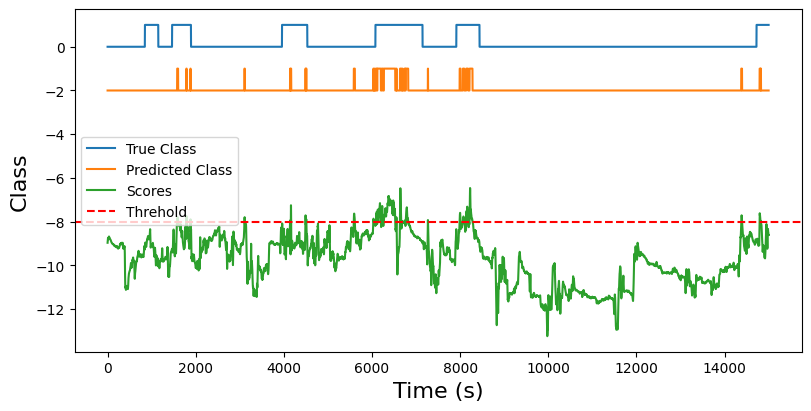

In [127]:
# EXECUTE CELL: Visualize the predictions made by the model in timeseries form
visualize_model_output_timeseries(y, preds, scores)

(3178, 11822)

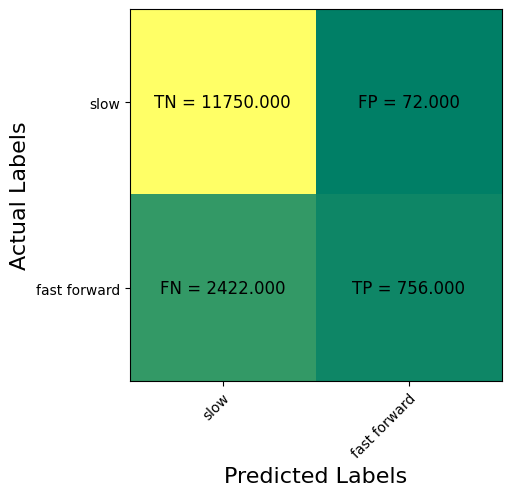

In [128]:
# EXECUTE CELL
display_confusion_matrix(y, preds, ['slow', 'fast forward'])


AUC: 0.8995988215803135


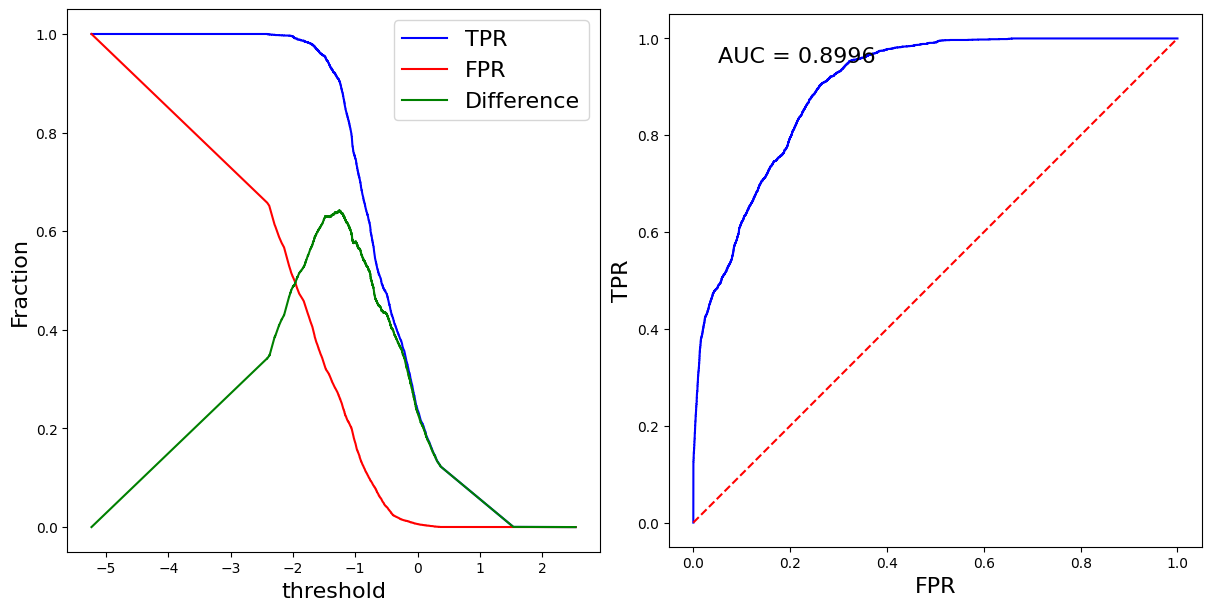

In [129]:
# EXECUTE CELL: Generate the TPR/FPR and ROC plots
fpr, tpr, thresholds, auc_res, fig, axs = ks_roc_plot(y, scores) 

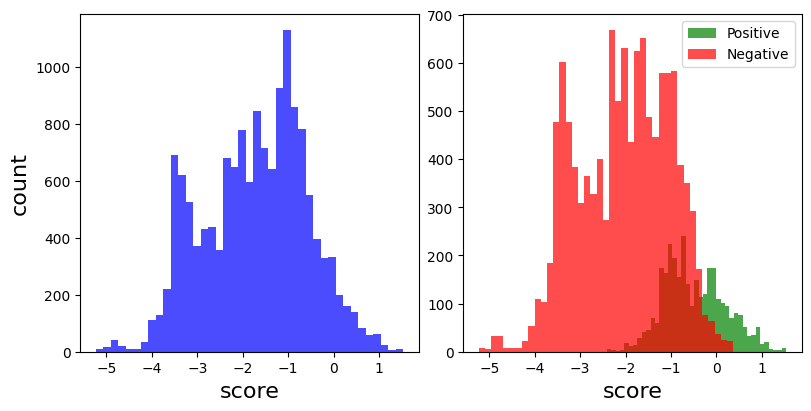

In [130]:
# EXECUTE CELL: Plot score histograms
plot_score_histograms(scores, y)

## Rotational Velocity Classifier

Create a new classifier that predicts the 'fast rotational velocity' label

In [131]:
""" TODO
"""
# Input
X = inputs_pos_vel

# Desired output
y = labels_rotational

# TODO: Create and fit the classifer
#loss ='loss_log' works for version 1.1 and up. Sklearn in Google Colab is at 1.02. Check version with sklearn.__version__
clf =  SGDClassifier(loss ='log', random_state =42 ,max_iter =1000 ,tol =1e-3)
clf.fit(X,y)

# TODO: extract the predictions and the decision function scores from the model for the entire data set
preds = clf.predict(X)

scores =clf.decision_function(X)

c:\Users\kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


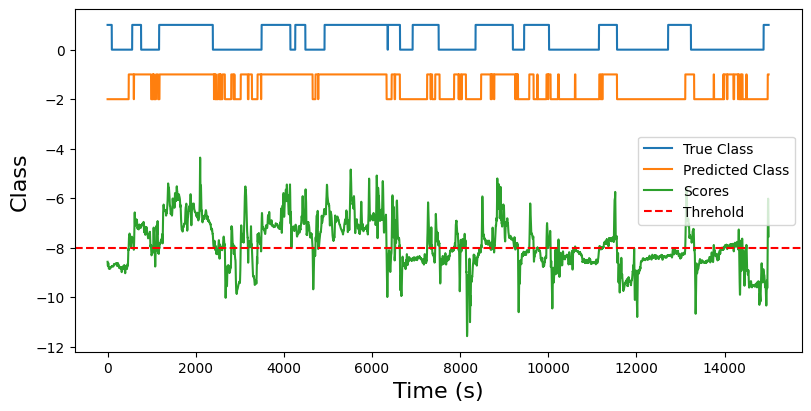

In [132]:
# EXECUTE CELL: Visualize the predictions made by the model in timeseries form
visualize_model_output_timeseries(y, preds, scores)

(7145, 7855)

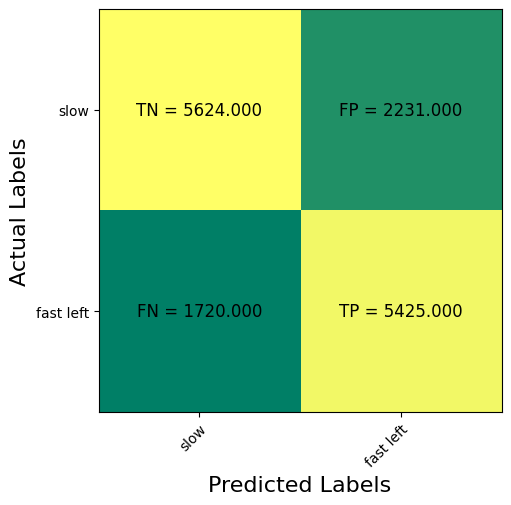

In [133]:
# EXECUTE CELL
display_confusion_matrix(y, preds, ['slow', 'fast left'])


AUC: 0.8326867973980817


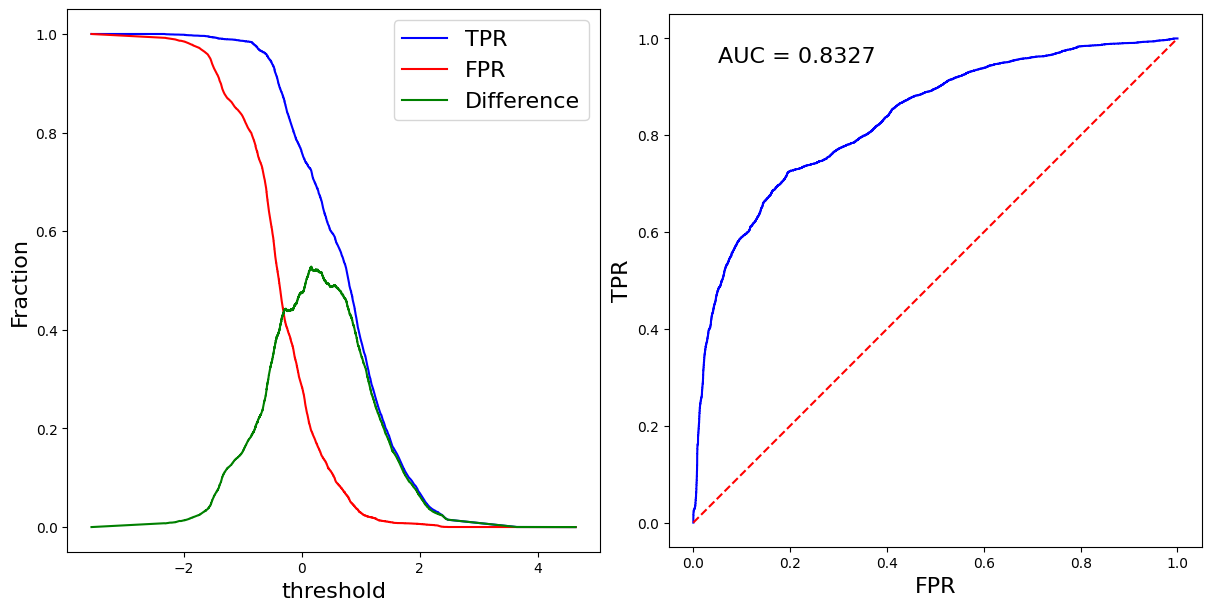

In [134]:
# EXECUTE CELL: Generate the TPR/FPR and ROC plots
fpr, tpr, thresholds, auc_res, fig, axs = ks_roc_plot(y, scores) 

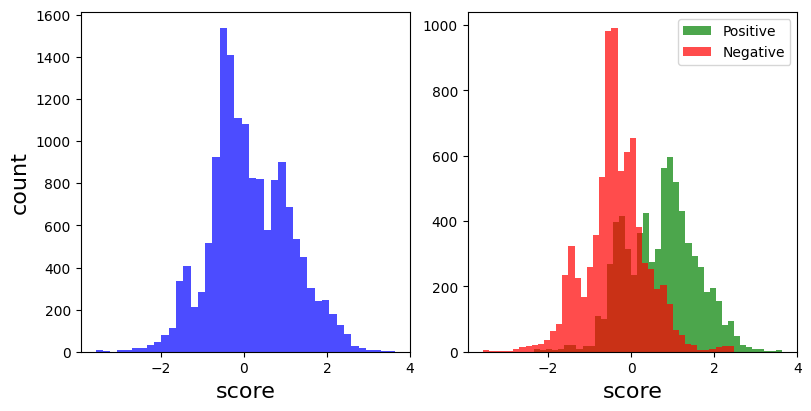

In [135]:
# EXECUTE CELL: Plot score histograms
plot_score_histograms(scores, y)

# Reflection
Please provide short answers to each of the questions

1. Comparing the two models, which one better separates the positive from the negative examples?  How are you evaluating this?

 AUC ,The area under the Curve shows that better separation between positive and Negative Samples.
 In Confusion Matrix ,The Higher no of TRUE POSITIVE(TP) AND TRUE NEGATIVE(TN) ,And Lower no of  FP AND FN ,Shows the Better Separation.
 Histograms , Better separation Indicates better Model performance.




2. Which of the two models exhibit the highest Kolmogorov-Schmirnov Distance?

 By comparing 2 models , We can see that The Kolmogorov- Schmirnov distance between the True Positive Rate and False Positive Rate. 


3. Did your pre-processing stage eliminate all of the NaNs in your data?  How do you know?

  Yes , We Eliminated Successfully All Nan Data. We can do it in preprocessing stage and check using isna() function in Pandas, followed by the any() function , And check if is any NaNs left in the DataFrame.




# Classification Using Cross Validation


In [136]:
""" TODO
LINEAR VELOCITY

Create a SGDClassifier with random_state=42, max_iter=1e4, tol=1e-3, and
that uses the log_loss function.  As before, this model will take as input
the positions and velocities & predict the robot linear velocity labels. 
However, we will use cross_val_predict() to fit N models, and compute 
predictions for each sample and their corresponding scores. Use 20 cross 
validation splits (i.e. cv=20).

"""
# Model input
X = inputs_pos_vel
# Model output
y = labels_linear

# TODO: Create and fit the classifer
#loss ='loss_log' works for version 1.1 and up. Sklearn in Google Colab is at 1.02. Check version with sklearn.__version__
clf3 = SGDClassifier(random_state=42, max_iter=10000, tol=1e-3, loss='log')

# TODO: use cross_val_predict() to compute the scores by setting the 'method'
#       parameter equal to 'decision_function'. Please see the reference 
#       links above
scores = cross_val_predict(clf3, X, y, cv=20, method='decision_function')


# TODO: use cross_val_predict() to compute the predicted labels by setting 
#       the 'method' parameter equal to 'predict'. Please see the reference 
#       links above
preds = cross_val_predict(clf3, X, y, cv=20, method='predict')

c:\Users\kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will

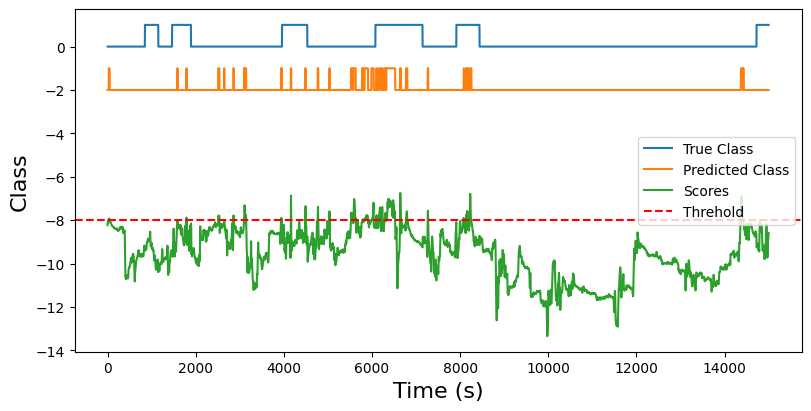

In [137]:
# EXECUTE CELL: Visualize the predictions made by the model in timeseries form
visualize_model_output_timeseries(y, preds, scores)

(3178, 11822)

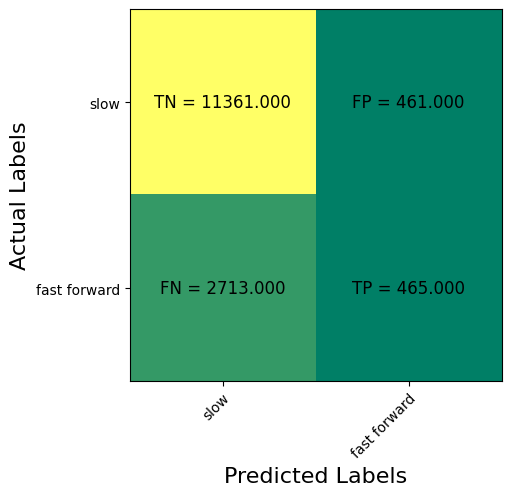

In [138]:
# EXECUTE CELL
display_confusion_matrix(y, preds, ['slow', 'fast forward'])


AUC: 0.7826021745465224
Best: 3168 -1.3687892729371498


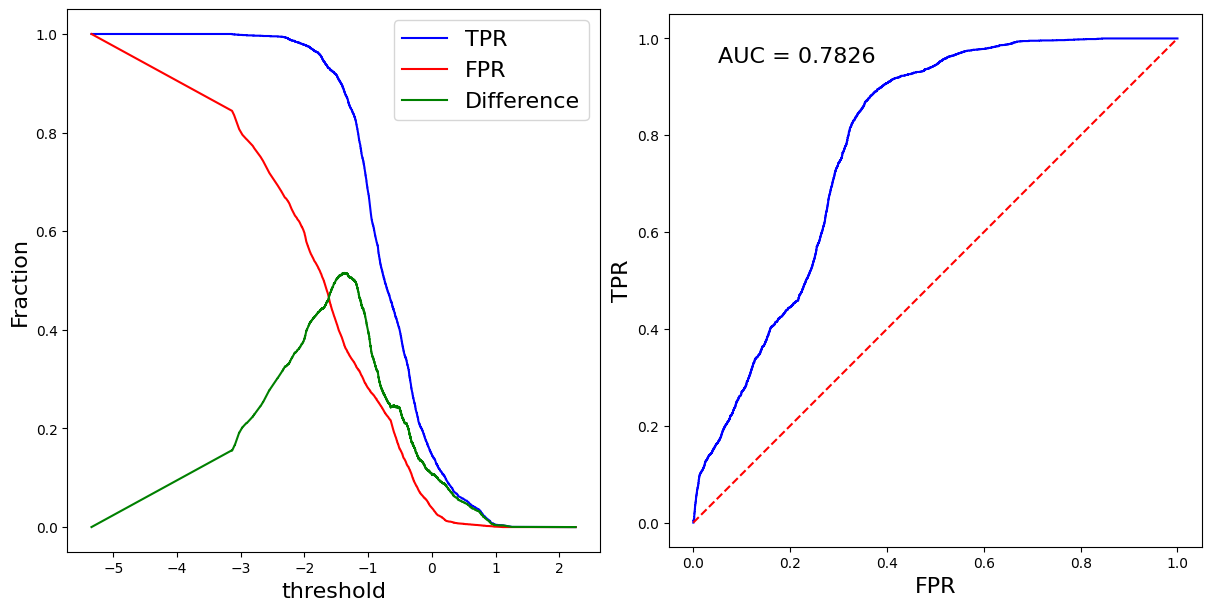

In [139]:
# EXECUTE CELL: Generate the TPR/FPR and ROC plots
fpr, tpr, thresholds, auc_res, fig, axs = ks_roc_plot(y, scores) 
x = np.argmax(tpr-fpr)
print("Best:", x, thresholds[x])

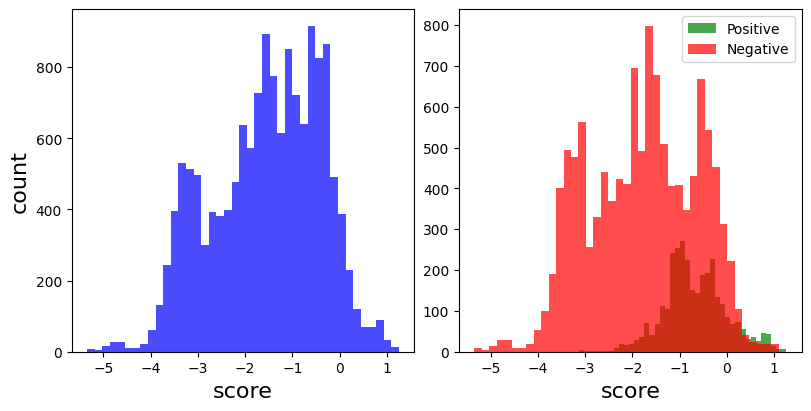

In [140]:
# Plot score histograms
plot_score_histograms(scores, y)

## Crossvalidation for Rotational Velocity

In [141]:
""" TODO
ROTATIONAL VELOCITY

Create a new SGDClassifier as above.  Train with positions and velocities 
and predict the rotational velocity labels.  
Use cross_val_predict() to fit N models and produce predictions and corresponding
scores for each sample.  Use 20 cross validation splits (i.e. cv=20).

"""
# Model input
X = inputs_pos_vel
# Model output
y = labels_rotational

# TODO: Create and fit the classifer
#loss ='loss_log' works for version 1.1 and up. Sklearn in Google Colab is at 1.02. Check version with sklearn.__version__
clf4 =  SGDClassifier(loss ='log',random_state =42 , max_iter =1000 , tol=1e-3)
#clf.fit(X, y)

# TODO: use cross_val_predict() to compute the scores by setting the 'method'
#       parameter equal to 'decision_function'. Please see the reference 
#       links above
scores = cross_val_predict(clf4, X,y , cv=20 ,method ='decision_function')
    
# TODO: use cross_val_predict() to compute the predicted labels by setting 
#       the 'method' parameter equal to 'predict'. Please see the reference 
#       links above
preds = cross_val_predict(clf4,X, y , cv=20 , method='predict')

c:\Users\kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
c:\Users\kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will

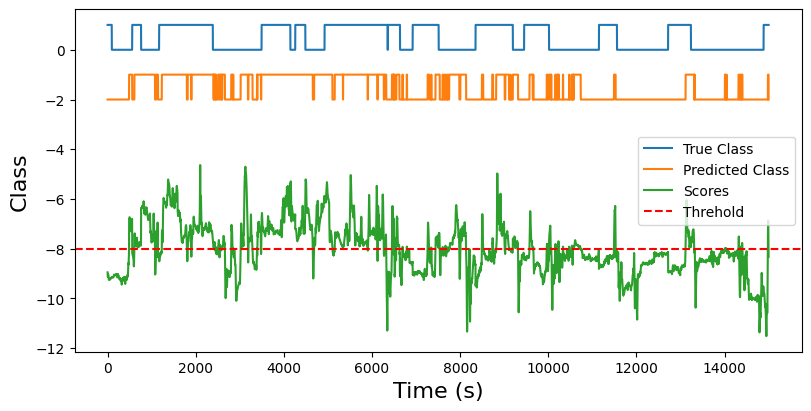

In [142]:
# EXECUTE CELL: Visualize the predictions made by the model in timeseries form
visualize_model_output_timeseries(y, preds, scores)

(7145, 7855)

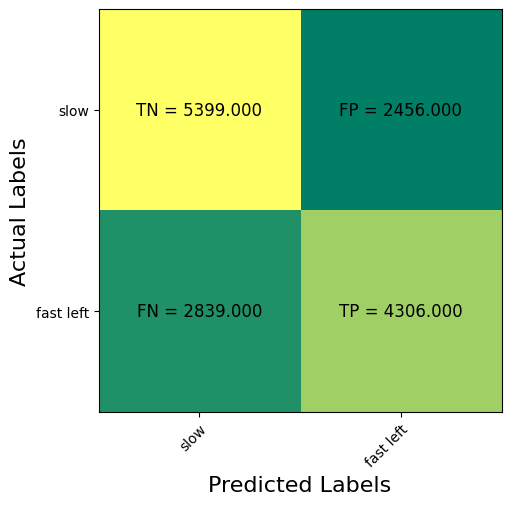

In [143]:
# EXECUTE CELL
display_confusion_matrix(y, preds, ['slow', 'fast left'])


AUC: 0.651574785998319
Best: 2558 0.10621842482402499


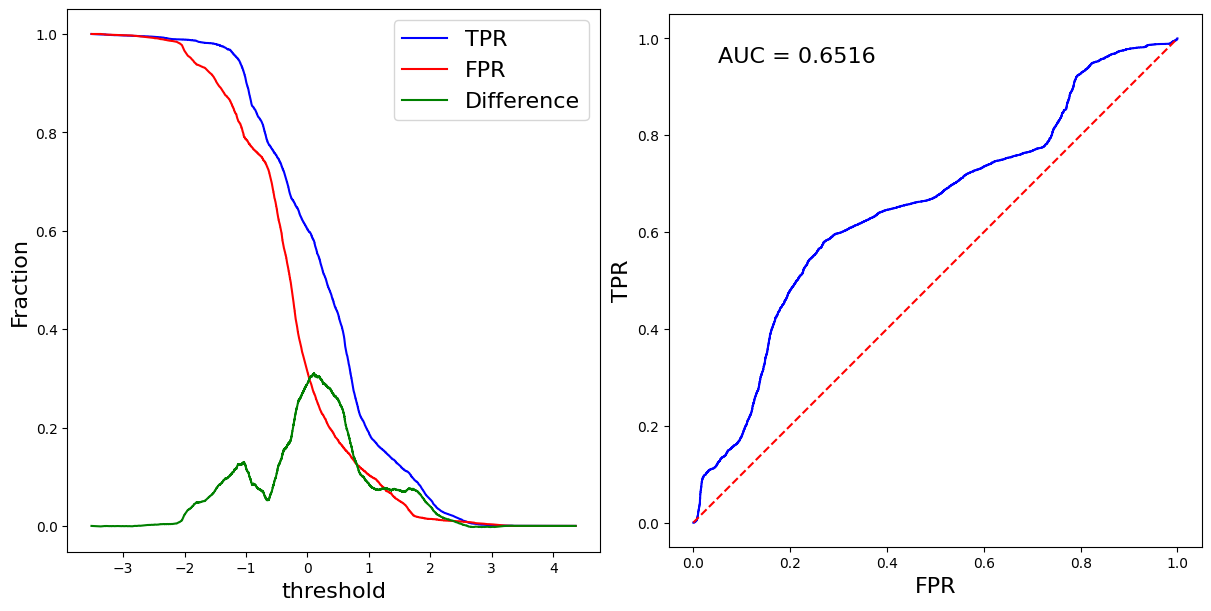

In [144]:
# EXECUTE CELL: Generate the TPR/FPR and ROC plots
fpr, tpr, thresholds, auc_res, fig, axs = ks_roc_plot(y, scores) 
x = np.argmax(tpr-fpr)
print("Best:", x, thresholds[x])

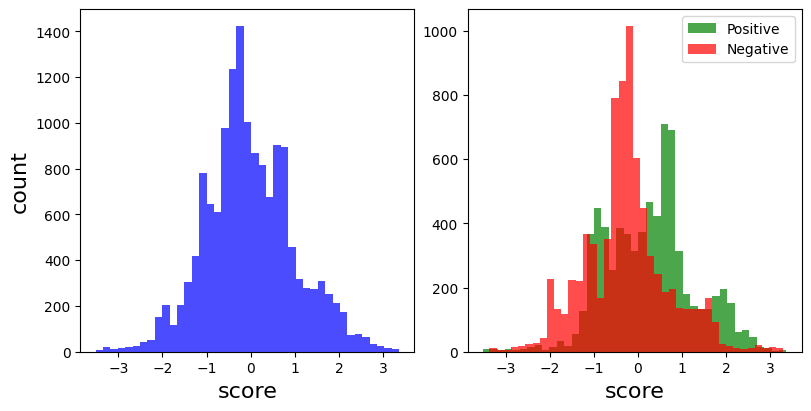

In [145]:
# Plot score histograms
plot_score_histograms(scores, y)

## Reflection, part 2

Write a short answer to each of the following questions:

1. Looking at the results from the first and second linear velocity models:  What is the difference in their performance and how do you explain this difference? 

### TODO


2. Looking at the results from the first and second rotational velocity models: which performance results are best to report when discussing model performance?

### TODO


3.  Looking at the linear velocity cross-validation TPR/FPR curves: what is the ideal threshold to use that distinquishes between the two classes?  Which threshold is used for the corresponding confusion matrix plot?

### TODO

4. Which of the two models (linear or rotational) perform best with respect to validation data?  Explain.


1) AUC =Area under the Curve is Very Less in the CrossValidation Model comapared with Other Model.
     In Confusion Matrix Higher no of TN , And low TP ,FN ,FP in CrossValidation Model Compared with Other model.
     
2)When Looking the Model , The Second Model the AUC =0.6516 Very less than the 1st model ,So 2nd Model is Considered Best.

3)   LinearVelocity Corss_Validation TPR/FPR curves is maximised , Which corresponds to the point closet to the top left corner of the ROC curve.

For Confusion Matrix default threshold 0.5 , Unless it is Specified.  

4)Linear Model perform best with respect validation data.When seeing the Result form Confusion matrix , ROC cruve and Histograms we cant stay that Linear model perform Best with respect to Validation of data.